# Multi-Class and Multi-Label Classification: SVM Analysis in Anuran Calls

In [3]:
import pandas as pd
import numpy as np

from sklearn.metrics import hamming_loss
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import KMeans


## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

### (a) Download data, choose 70% of the data randomly as the training set

In [4]:
df = pd.read_csv('./Data/Frogs_MFCCs.csv')
df_train, df_test = train_test_split(df, train_size=0.7, shuffle=True)

### (b) Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-label classification is to train a classifier for each label (binary relevance). We first try this approach: 

#### i.i. Research exact match and hamming score/ loss methods for evaluating multi-label classification and use them in evaluating the classifiers in this problem

In [7]:
labels = ['Family', 'Genus', 'Species']

x_train = df_train.iloc[:,0:22]
x_test = df_test.iloc[:,0:22]
y_train = df_train[labels]
y_test = df_test[labels]

for label in labels:
    # Using OneVsRestClassifier with Logistic Regression
    classifier = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)
    
    classifier.fit(x_train, y_train[label])
    prediction = classifier.predict(x_test)
    
    hamming_loss_value = hamming_loss(y_test[label], prediction)
    exact_match_score = accuracy_score(y_test[label], prediction)
    
    print(label)
    print('Hamming Loss:', hamming_loss_value)
    print('Exact Match score:', (exact_match_score))

Family
Hamming Loss: 0.07549791570171376
Exact Match score: 0.9245020842982863
Genus
Hamming Loss: 0.07642427049559981
Exact Match score: 0.9235757295044001
Species
Hamming Loss: 0.07086614173228346
Exact Match score: 0.9291338582677166


#### ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation. 

In [4]:
# Define a dictionary to store the best hyperparameters for each label
best_params = {}
# Define a grid of hyperparameters to search
param_grid = {
        'C': np.logspace(-3, 6, num=10),  # Penalty parameter
        'gamma': np.linspace(0.1, 4, 10)  # Kernel width
}

In [5]:
for label in labels:
    print(f"Training SVM for label: {label}")
    
    # Create an SVM classifier with a Gaussian kernel
    svm = SVC(kernel='rbf')
    
    # Perform 10-fold cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(svm, param_grid, cv=10, n_jobs=-1)
    grid_search.fit(x_train, y_train[label])
    
    # Store the best hyperparameters
    best_params[label] = grid_search.best_params_
    
    # Train a one-versus-all SVM classifier with the best hyperparameters
    best_svm = SVC(kernel='rbf', C=best_params[label]['C'], gamma=best_params[label]['gamma'])
    best_svm.fit(x_train, y_train[label])
    y_pred = best_svm.predict(x_test)
    hamming_loss_value = hamming_loss(y_test[label], y_pred)
    exact_match_score = accuracy_score(y_test[label], y_pred)
    
    
    # Evaluate the SVM classifier on the test data
    
    print(f"Label: {label}")
    print("Best Hyperparameters:", best_params[label])
    print('Hamming Loss:', hamming_loss_value)
    print('Exact Match score:', (exact_match_score))
    print(classification_report(y_test[label], y_pred))


Training SVM for label: Family
Label: Family
Best Hyperparameters: {'C': 10.0, 'gamma': 3.1333333333333333}
Hamming Loss: 0.007410838351088467
Exact Match score: 0.9925891616489115
                 precision    recall  f1-score   support

      Bufonidae       0.90      0.90      0.90        21
  Dendrobatidae       1.00      1.00      1.00       160
        Hylidae       0.99      0.99      0.99       658
Leptodactylidae       1.00      0.99      1.00      1320

       accuracy                           0.99      2159
      macro avg       0.97      0.97      0.97      2159
   weighted avg       0.99      0.99      0.99      2159

Training SVM for label: Genus
Label: Genus
Best Hyperparameters: {'C': 10.0, 'gamma': 3.1333333333333333}
Hamming Loss: 0.012042612320518759
Exact Match score: 0.9879573876794813
               precision    recall  f1-score   support

    Adenomera       0.99      1.00      0.99      1236
     Ameerega       1.00      1.00      1.00       160
Dendropsophus  

### iii. Repeat 1(b)ii with L1-penalized SVMs. Remember to standardize the attributes. Determine the weight of the SVM penalty using 10 fold cross validation

In [6]:
best_params_l1 = {}
param_grid2 = {
    'C': np.logspace(-3, 6, num=10),  # Penalty parameter
}

for label in labels:
    print(f"Training L1-penalized SVM for label: {label}")

    # Create an L1-penalized SVM classifier (LinearSVC)
    svm = LinearSVC(penalty='l1', dual=False, multi_class='ovr', max_iter=100000,tol=1e-3)
    
    # Perform 10-fold cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(svm, param_grid2, cv=10, n_jobs=-1)
    grid_search.fit(x_train, y_train[label])

    best_params_l1[label] = grid_search.best_params_

    # Train an L1-penalized SVM classifier with the best hyperparameters
    best_svm = LinearSVC(penalty='l1', C=best_params_l1[label]['C'], dual=False, max_iter=100000) 
    best_svm.fit(x_train, y_train[label])

    # Evaluate the L1-penalized SVM classifier on the test data
    y_pred = best_svm.predict(x_test)
    
    hamming_loss_value = hamming_loss(y_test[label], y_pred)
    exact_match_score = accuracy_score(y_test[label], y_pred)
    print(f"Label: {label}")
    print("Best Hyperparameters:", best_params_l1[label])
    print('Hamming Loss:', hamming_loss_value)
    print('Exact Match score:', (exact_match_score))   
    print(classification_report(y_test[label], y_pred))

Training L1-penalized SVM for label: Family
Label: Family
Best Hyperparameters: {'C': 10.0}
Hamming Loss: 0.07086614173228346
Exact Match score: 0.9291338582677166
                 precision    recall  f1-score   support

      Bufonidae       0.00      0.00      0.00        21
  Dendrobatidae       0.89      0.93      0.91       160
        Hylidae       0.91      0.87      0.89       658
Leptodactylidae       0.95      0.97      0.96      1320

       accuracy                           0.93      2159
      macro avg       0.69      0.69      0.69      2159
   weighted avg       0.92      0.93      0.92      2159

Training L1-penalized SVM for label: Genus


/Users/jz/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Label: Genus
Best Hyperparameters: {'C': 100000.0}
Hamming Loss: 0.0444650301065308
Exact Match score: 0.9555349698934692
               precision    recall  f1-score   support

    Adenomera       0.97      0.99      0.98      1236
     Ameerega       0.95      0.97      0.96       160
Dendropsophus       0.94      0.74      0.83        97
    Hypsiboas       0.93      0.97      0.95       470
Leptodactylus       0.97      0.90      0.94        84
Osteocephalus       0.94      0.41      0.58        41
     Rhinella       0.85      0.81      0.83        21
       Scinax       1.00      0.94      0.97        50

     accuracy                           0.96      2159
    macro avg       0.94      0.84      0.88      2159
 weighted avg       0.96      0.96      0.95      2159

Training L1-penalized SVM for label: Species
Label: Species
Best Hyperparameters: {'C': 1000.0}
Hamming Loss: 0.03844372394627142
Exact Match score: 0.9615562760537286
                        precision    recall  f1

/Users/jz/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### iv. Repeat 1(b)iii by using SMOTE to remedy class imbalance. Report conclusions about the classifiers trained.

In [8]:
from imblearn.over_sampling import SMOTE
best_params_smote = {}
param_grid3 = {
    'C': np.logspace(-3, 6, num=10),  # Penalty parameter
    'gamma': np.linspace(0.1, 4, 10)  # Kernel width
}
smote = SMOTE(random_state=42)

In [10]:
for label in labels:
    print(f"Training SVM with SMOTE for label: {label}")
    # Resample the training data using SMOTE for the current label
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train[label])

    # Initialize an SVM classifier
    svm = SVC(kernel='rbf')

    # Perform grid search over the parameter grid
    grid_search = GridSearchCV(svm, param_grid3, cv=10, n_jobs=-1)
    grid_search.fit(x_train_resampled, y_train_resampled)

    # Store the best parameters
    best_params_smote[label] = grid_search.best_params_

    # Train an SVM classifier with the best found hyperparameters for the current label
    svm_best = SVC(kernel='rbf', C=best_params_smote[label]['C'], gamma=best_params_smote[label]['gamma'])
    svm_best.fit(x_train_resampled, y_train_resampled)

    # Evaluate the classifier on the test data
    y_pred = svm_best.predict(x_test)

    # Calculate evaluation metrics
    hamming_loss_value = hamming_loss(y_test[label], y_pred)
    exact_match_score = accuracy_score(y_test[label], y_pred)

    # Output results
    print(f"Label: {label}")
    print("Best Hyperparameters:", best_params_smote[label])
    print('Hamming Loss:', hamming_loss_value)
    print('Exact Match score:', exact_match_score)
    print(classification_report(y_test[label], y_pred))


Training SVM with SMOTE for label: Family
Label: Family
Best Hyperparameters: {'C': 10.0, 'gamma': 1.8333333333333335}
Hamming Loss: 0.006947660954145438
Exact Match score: 0.9930523390458545
                 precision    recall  f1-score   support

      Bufonidae       1.00      0.96      0.98        23
  Dendrobatidae       0.99      0.99      0.99       181
        Hylidae       0.98      1.00      0.99       631
Leptodactylidae       1.00      0.99      1.00      1324

       accuracy                           0.99      2159
      macro avg       0.99      0.98      0.99      2159
   weighted avg       0.99      0.99      0.99      2159

Training SVM with SMOTE for label: Genus
Label: Genus
Best Hyperparameters: {'C': 10.0, 'gamma': 3.566666666666667}
Hamming Loss: 0.007410838351088467
Exact Match score: 0.9925891616489115
               precision    recall  f1-score   support

    Adenomera       1.00      1.00      1.00      1239
     Ameerega       0.99      1.00      1.00     

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set 
## Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances.

### (a). Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). 

In [43]:
X = df.iloc[:,:-4]

The optimal number of clusters is: 4


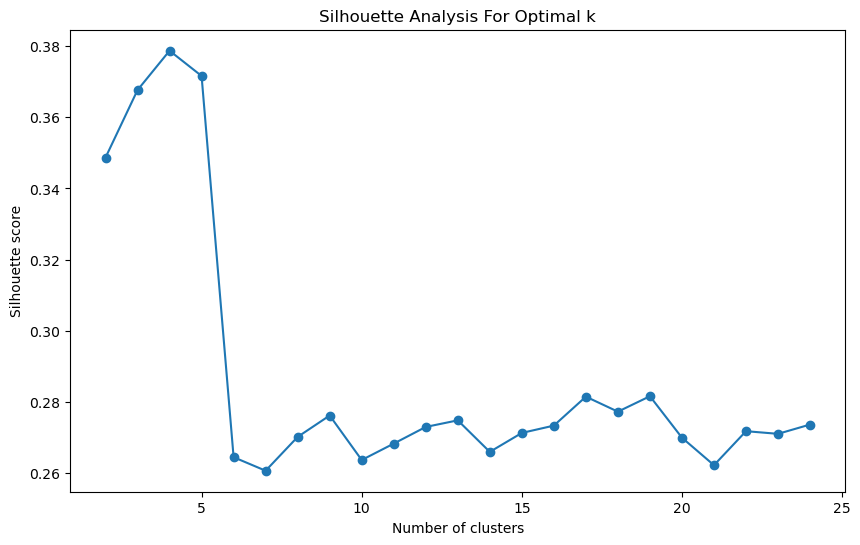

In [53]:
silhouette_scores = []
for k in range(2, 25):  # silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Assign the KMeans object to a variable
    cluster_labels = kmeans.fit_predict(X)  # Fit the model and predict the cluster labels for X
    silhouette_avg = silhouette_score(X, cluster_labels)  # Calculate the average silhouette score
    silhouette_scores.append(silhouette_avg)  # Append the silhouette score to the list

optimal_k = range(2, 25)[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {optimal_k}")

# Plot the silhouette scores vs. k values
plt.figure(figsize=(10, 6))
plt.plot(range(2, 25), silhouette_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis For Optimal k")
plt.show()

For n_clusters = 4, the average silhouette_score is :0.3787509343305295


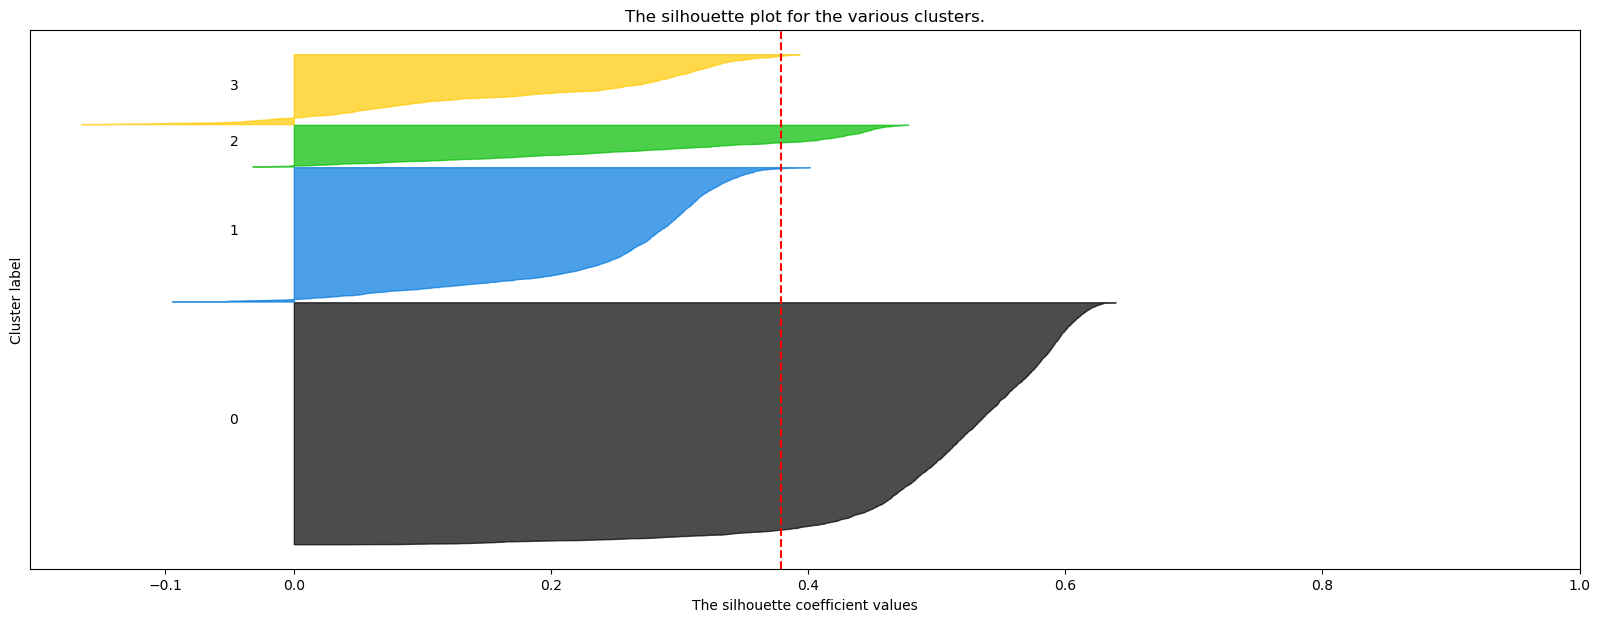

In [41]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print(f"For n_clusters = {optimal_k}, the average silhouette_score is :{silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
plt.figure(figsize=(20, 7))

for i in range(optimal_k):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / optimal_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples gap

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


### (b) In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species. 

In [45]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

# For family
for i in range(optimal_k):
    cluster_family_mode = df[df['cluster'] == i]['Family'].mode()[0]
    print(f"The most common family in cluster {i} is: {cluster_family_mode}")

# For genus
for i in range(optimal_k):
    cluster_genus_mode = df[df['cluster'] == i]['Genus'].mode()[0]
    print(f"The most common genus in cluster {i} is: {cluster_genus_mode}")

# For species
for i in range(optimal_k):
    cluster_species_mode = df[df['cluster'] == i]['Species'].mode()[0]
    print(f"The most common species in cluster {i} is: {cluster_species_mode}")


The most common family in cluster 0 is: Leptodactylidae
The most common family in cluster 1 is: Hylidae
The most common family in cluster 2 is: Hylidae
The most common family in cluster 3 is: Dendrobatidae
The most common genus in cluster 0 is: Adenomera
The most common genus in cluster 1 is: Hypsiboas
The most common genus in cluster 2 is: Hypsiboas
The most common genus in cluster 3 is: Ameerega
The most common species in cluster 0 is: AdenomeraHylaedactylus
The most common species in cluster 1 is: HypsiboasCordobae
The most common species in cluster 2 is: HypsiboasCinerascens
The most common species in cluster 3 is: Ameeregatrivittata


### (c) Now for each cluster I have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss between the true labels and the labels assigned by clusters.

In [48]:
# Create a mapping from clusters to majority labels
majority_label_mapping = {}

for cluster_num in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_num]
    majority_family = cluster_data['Family'].mode()[0]
    majority_genus = cluster_data['Genus'].mode()[0]
    majority_species = cluster_data['Species'].mode()[0]
    majority_label_mapping[cluster_num] = (majority_family, majority_genus, majority_species)

# Assign majority labels to each instance based on cluster
for cluster_num, majority_labels in majority_label_mapping.items():
    df.loc[df['cluster'] == cluster_num, 'majority_Family'] = majority_labels[0]
    df.loc[df['cluster'] == cluster_num, 'majority_Genus'] = majority_labels[1]
    df.loc[df['cluster'] == cluster_num, 'majority_Species'] = majority_labels[2]

# Define the function to calculate Hamming distance for a row
def calculate_hamming_distance(row, label_columns):
    return sum(row[label] != row['majority_' + label] for label in label_columns) / len(label_columns)

# Calculate Hamming distance for each row
df['hamming_distance'] = df.apply(lambda row: calculate_hamming_distance(row, ['Family', 'Genus', 'Species']), axis=1)

# Calculate the average Hamming distance, score, and loss
average_hamming_distance = df['hamming_distance'].mean()
hamming_score = 1 - average_hamming_distance  # Hamming score is 1 - Hamming loss
hamming_loss_value = average_hamming_distance  # Hamming loss is equivalent to the average Hamming distance here

print(f"Average Hamming Distance: {average_hamming_distance}")
print(f"Hamming Score: {hamming_score}")
print(f"Hamming Loss: {hamming_loss_value}")


Average Hamming Distance: 0.22242297892054666
Hamming Score: 0.7775770210794534
Hamming Loss: 0.22242297892054666


## 3. ISLR 12.6.2

### (a)

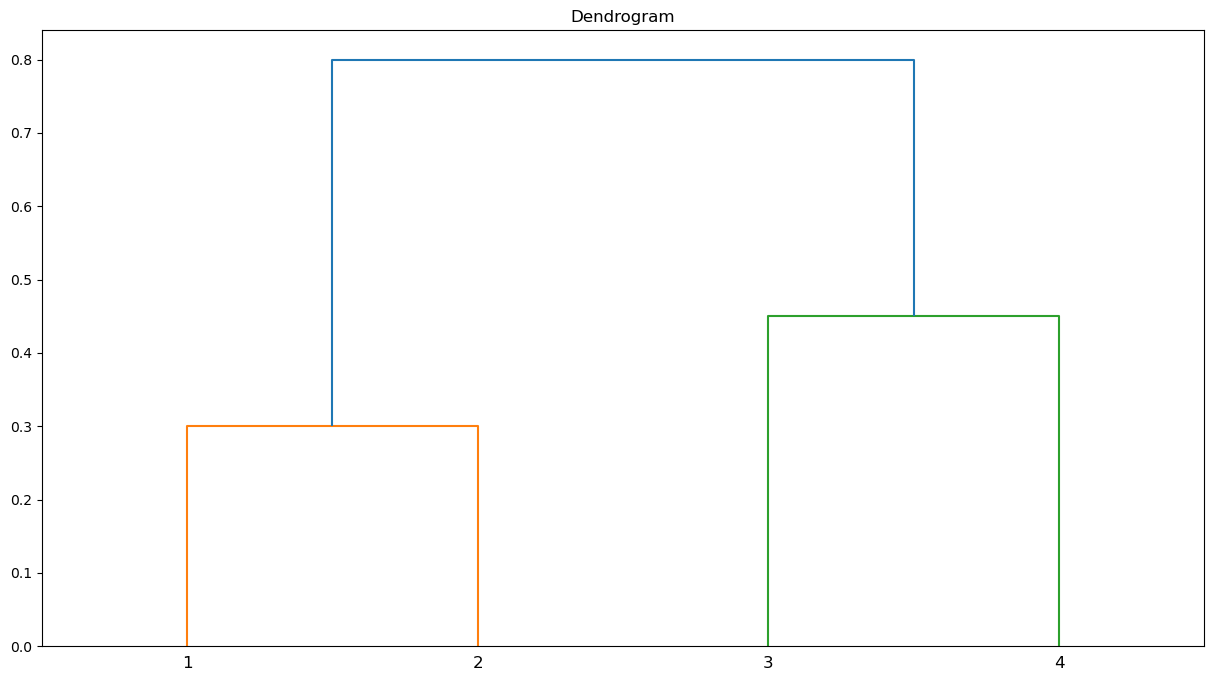

In [1]:
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt

dis_mat = np.array([[0.0, 0.3, 0.4, 0.7], [0.3, 0.0, 0.5, 0.8], [0.4, 0.5, 0.0, 0.45], [0.7, 0.8, 0.45, 0.0]])
dists = squareform(dis_mat)
linkage_matrix = linkage(dists, "complete")
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
dendrogram(linkage_matrix, labels=["1", "2", "3", "4"])
plt.title("Dendrogram")
plt.show()


### (b)

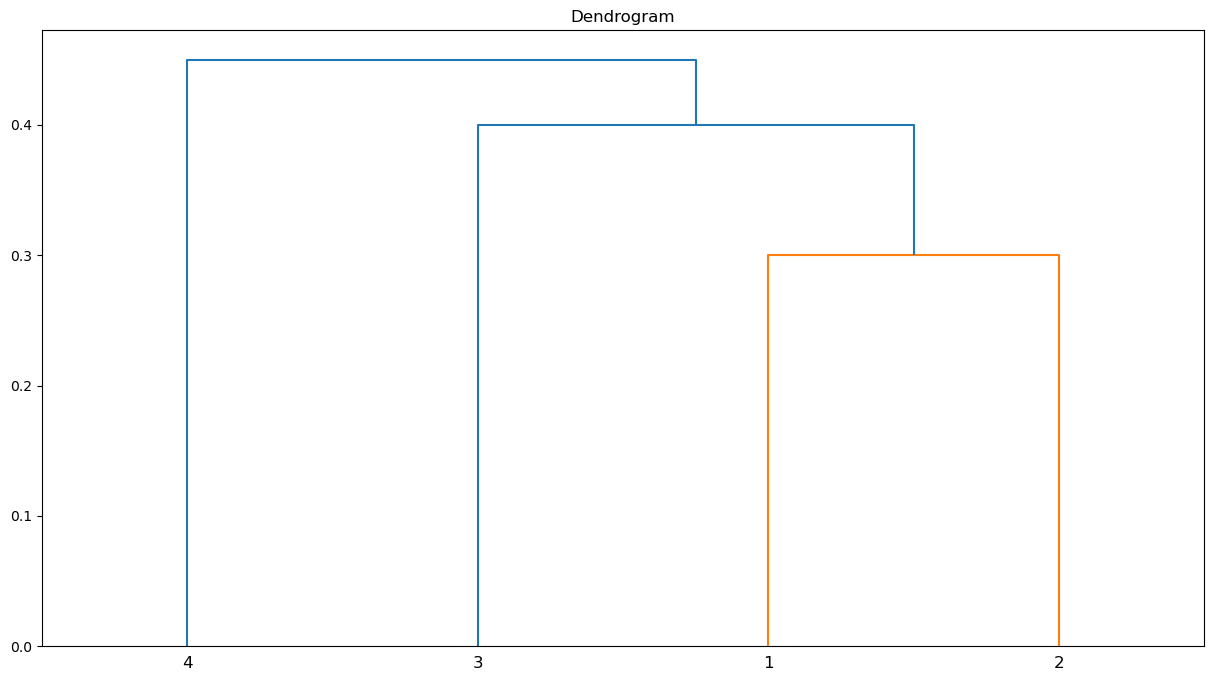

In [2]:
linkage_matrix = linkage(dists, "single")
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
dendrogram(linkage_matrix, labels=["1", "2", "3", "4"])
plt.title("Dendrogram")
plt.show()

### (c). 
Observations 1 and 2 are in Cluster A and 3 and 4 in Cluster B.

### (d).
Observations 1, 2 and 3 are in Cluster A and 4 in Cluster B.

### (e).


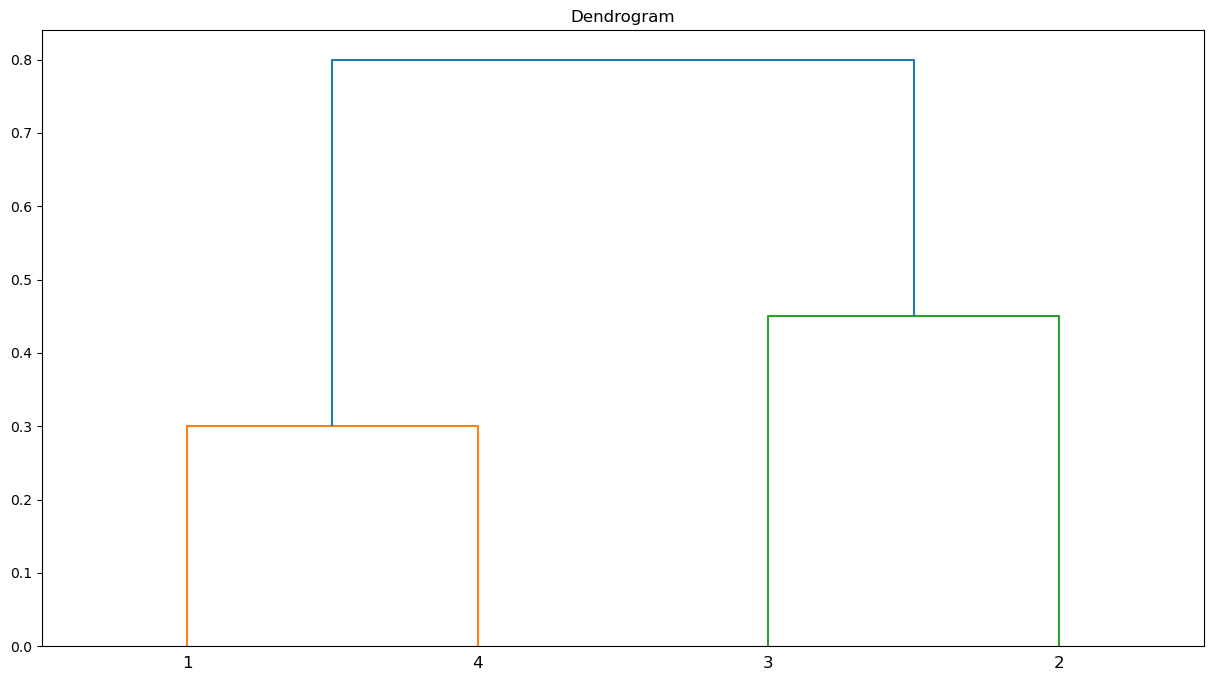

In [3]:
dis_mat = np.array([[0.0, 0.3, 0.4, 0.7], [0.3, 0.0, 0.5, 0.8], [0.4, 0.5, 0.0, 0.45], [0.7, 0.8, 0.45, 0.0]])
dists = squareform(dis_mat)
linkage_matrix = linkage(dists, "complete")
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
dendrogram(linkage_matrix, labels=["1", "4", "3", "2"])
plt.title("Dendrogram")
plt.show()